Error between the prediction and the analytical solution: 41.82936976414939


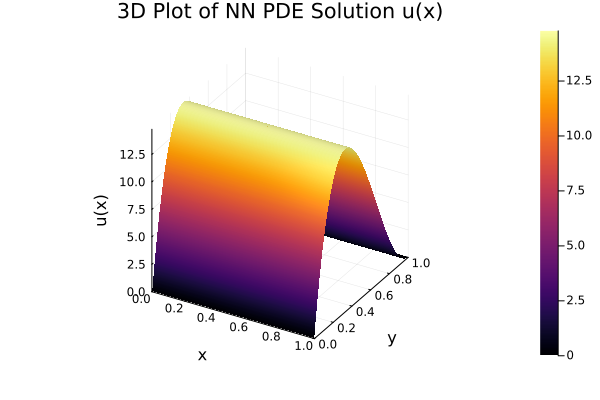

In [1]:
using Flux, Optim
using Flux: params, train!
using Zygote, Random, Plots, Statistics, Plots

# Neural network
nn = Chain(Dense(1, 64, tanh), Dense(64, 1))

L = 1.0
α = 0.01
u0 = 100.0
uL = 0.0

# Trial function with boundary conditions
function u(x, nn)
    x = Float32(x)
    return (1 - x) * x * (nn([x])[1] + u0 + (uL - u0) * x / L)
end
# Exact analytical solution
function analytical_solution(x)
    A = u0
    B = (uL - u0 * cos(sqrt(α) * L)) / sin(sqrt(α) * L)
    return A * cos(sqrt(α) * x) + B * sin(sqrt(α) * x)
end

function calculate_error(u, nn, reference_solution, resolution=100)
    x_range = range(0, stop=L, length=resolution)
    errors = [abs(u(x, nn) - reference_solution(x)) for x in x_range]
    return mean(errors)
end

# Loss function
function loss(x, nn)
    u_pred = u(x, nn)
    h = 1e-5
    u_xx = (u(x + h, nn) - 2 * u_pred + u(x - h, nn)) / h^2
    return (u_xx + α*u_pred)^2
end

batch_size = 1000

function train_pde_solver(nn, epochs, batch_size)
    opt = ADAM(0.01)
    ps = params(nn)

    for epoch in 1:epochs
        batch_x = Float32.(L * rand(batch_size))
        avg_loss = mean(x -> loss(x, nn), batch_x)

        grads = gradient(() -> avg_loss, ps)
        Flux.Optimise.update!(opt, ps, grads)
    end
end

function reference_solution(x)
    # Placeholder
    return u0 + (uL - u0) * x / L
end

function calculate_error(u, nn, reference_solution, resolution=100)
    x_range = range(0, stop=L, length=resolution)
    errors = [abs(u(x, nn) - reference_solution(x)) for x in x_range]
    return mean(errors)
end

function plot_solution_1d(u, nn, resolution=1000)
    x_range = range(0, stop=L, length=resolution)
    u_values = [u(x, nn) for x in x_range]
    plot(x_range, u_values, xlabel="x", ylabel="u(x)", title="NN PDE Solution u(x)", label="NN solution")
    plot!(x_range, [reference_solution(x) for x in x_range], linestyle=:dash, label="Reference solution")
end

train_pde_solver(nn, 5000, batch_size)
error = calculate_error(u, nn, analytical_solution)
println("Error between the prediction and the analytical solution: $error")

function plot_solution_1d(u, nn, resolution=1000)
    x_range = range(0, stop=L, length=resolution)
    u_values = [u(x, nn) for x in x_range]
    plot(x_range, u_values, xlabel="x", ylabel="u(x)", title="NN PDE Solution vs. Analytical Solution", label="NN solution")
    plot!(x_range, [analytical_solution(x) for x in x_range], linestyle=:dash, label="Analytical solution")
end

function plot_solution_3d(u, nn, resolution=1000)
    x_range = range(0, stop=L, length=resolution)
    y_range = range(0, stop=L, length=resolution) # simply a dummy axis for 3D plot
    z = [u(x, nn) for x in x_range, _ in y_range]
    
    plot(x_range, y_range, z, st=:surface, xlabel="x", ylabel="y", zlabel="u(x)", title="3D Plot of NN PDE Solution u(x)")
end

plot_solution_3d(u, nn)

